 ### Import Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import tifffile as tiff
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, UpSampling2D, SpatialDropout2D,concatenate, Activation, Conv2DTranspose, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal
from sklearn.preprocessing import MinMaxScaler

### Load and Explore Dataset

In [4]:
def load_images_and_labels(data_path):
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')
    
    image_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
    label_files = [f for f in os.listdir(labels_path) if f.endswith('.png')]
    
    images = []
    labels = []
    
    for img_file, lbl_file in zip(image_files, label_files):
        img = tiff.imread(os.path.join(images_path, img_file))
       # Load the label .png image, convert to numpy array and normalize
        lbl = Image.open(os.path.join(labels_path, lbl_file))
        lbl = np.array(lbl).astype(np.float32)
        
        # Labels should be binary (0 and 1), so ensure proper normalization
        #lbl = lbl / 255.0
        
        images.append(img)
        labels.append(lbl)
    
    return np.array(images), np.array(labels)

data_path = r"D:\Mohamed Sheriff\Projects\Computer Vision Internship - Cellula Technologies\Water Segementation\Dataset"
images, labels = load_images_and_labels(data_path)

print(f"Loaded {len(images)} images with shape {images[0].shape} and {len(labels)} labels with shape {labels[0].shape}")

Loaded 306 images with shape (128, 128, 12) and 306 labels with shape (128, 128)


### Normalize Data

In [6]:
def normalize_image_with_minmax(image):
    scaler = MinMaxScaler()
    # Reshape the image from (height, width, channels) to (num_pixels, channels)
    height, width, channels = image.shape
    image_flattened = image.reshape(-1, channels)
    
    # Apply MinMaxScaler to each channel
    image_scaled = scaler.fit_transform(image_flattened)
    
    # Reshape back to original image dimensions
    image_normalized = image_scaled.reshape(height, width, channels)
    return image_normalized

# Apply the normalization to all images
images = np.array([normalize_image_with_minmax(img) for img in images])

#### Normalized Difference Water Index Composite $(NDWI)$

In [7]:
def ndwi(image):
    green_band = image[:, :, 2]  # Assuming Band 2 is Green
    nir_band = image[:, :, 4]    # Assuming Band 4 is NIR
    multispectral_images = (green_band - nir_band) / (green_band + nir_band + 1e-10)  # Avoid division by zero
    return multispectral_images

### Visualize Data

#### Visualize all 12 bands

Image 1 shape: (128, 128, 12)


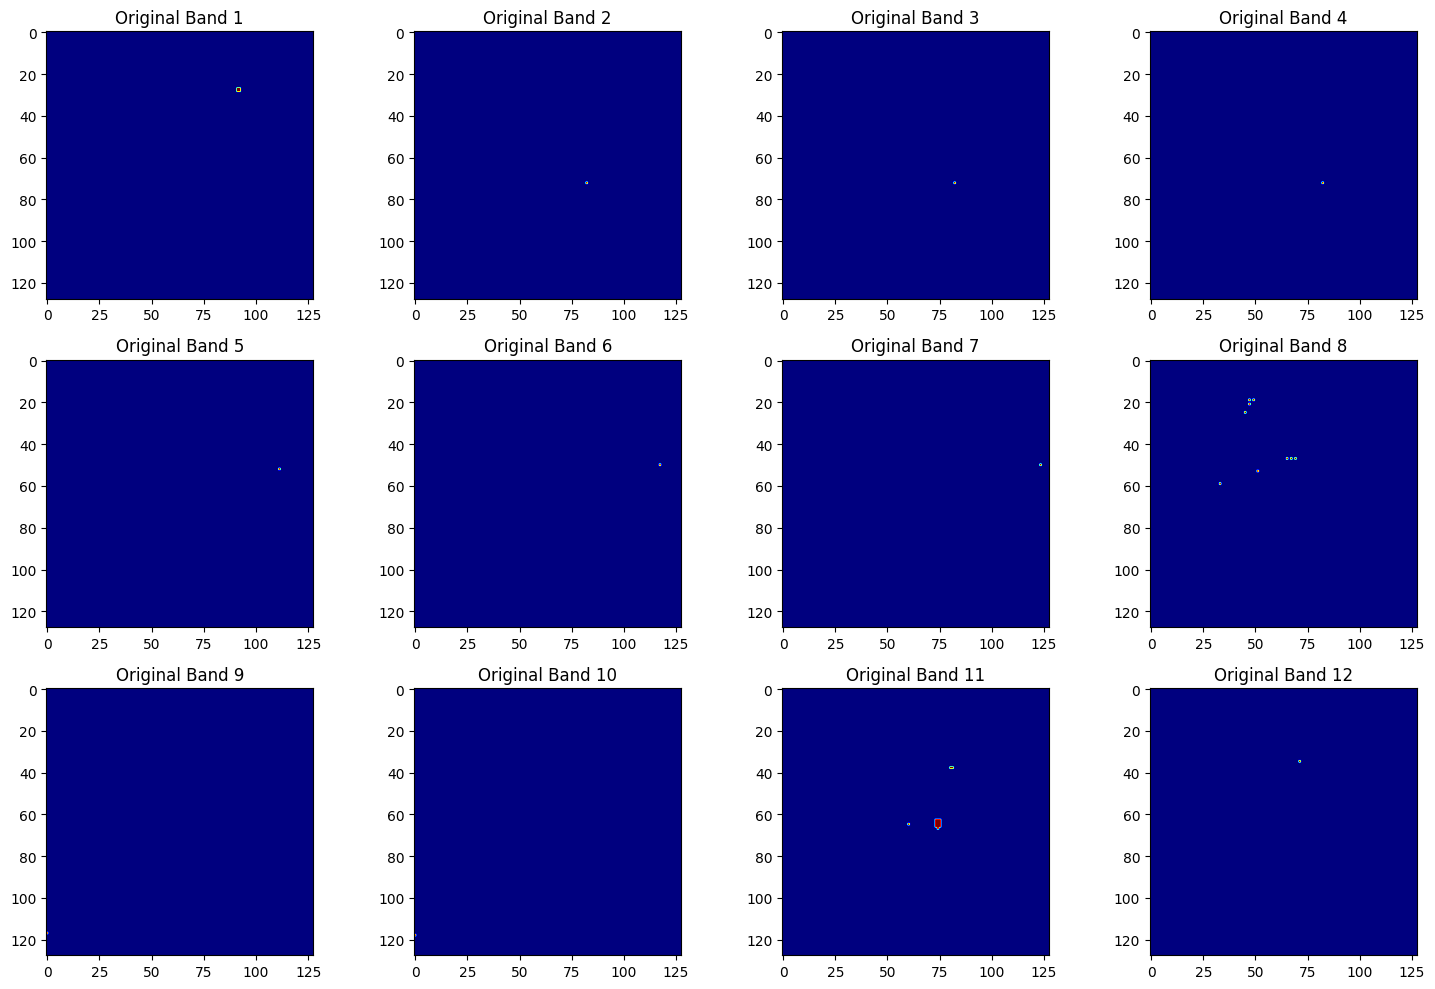

Image 2 shape: (128, 128, 12)


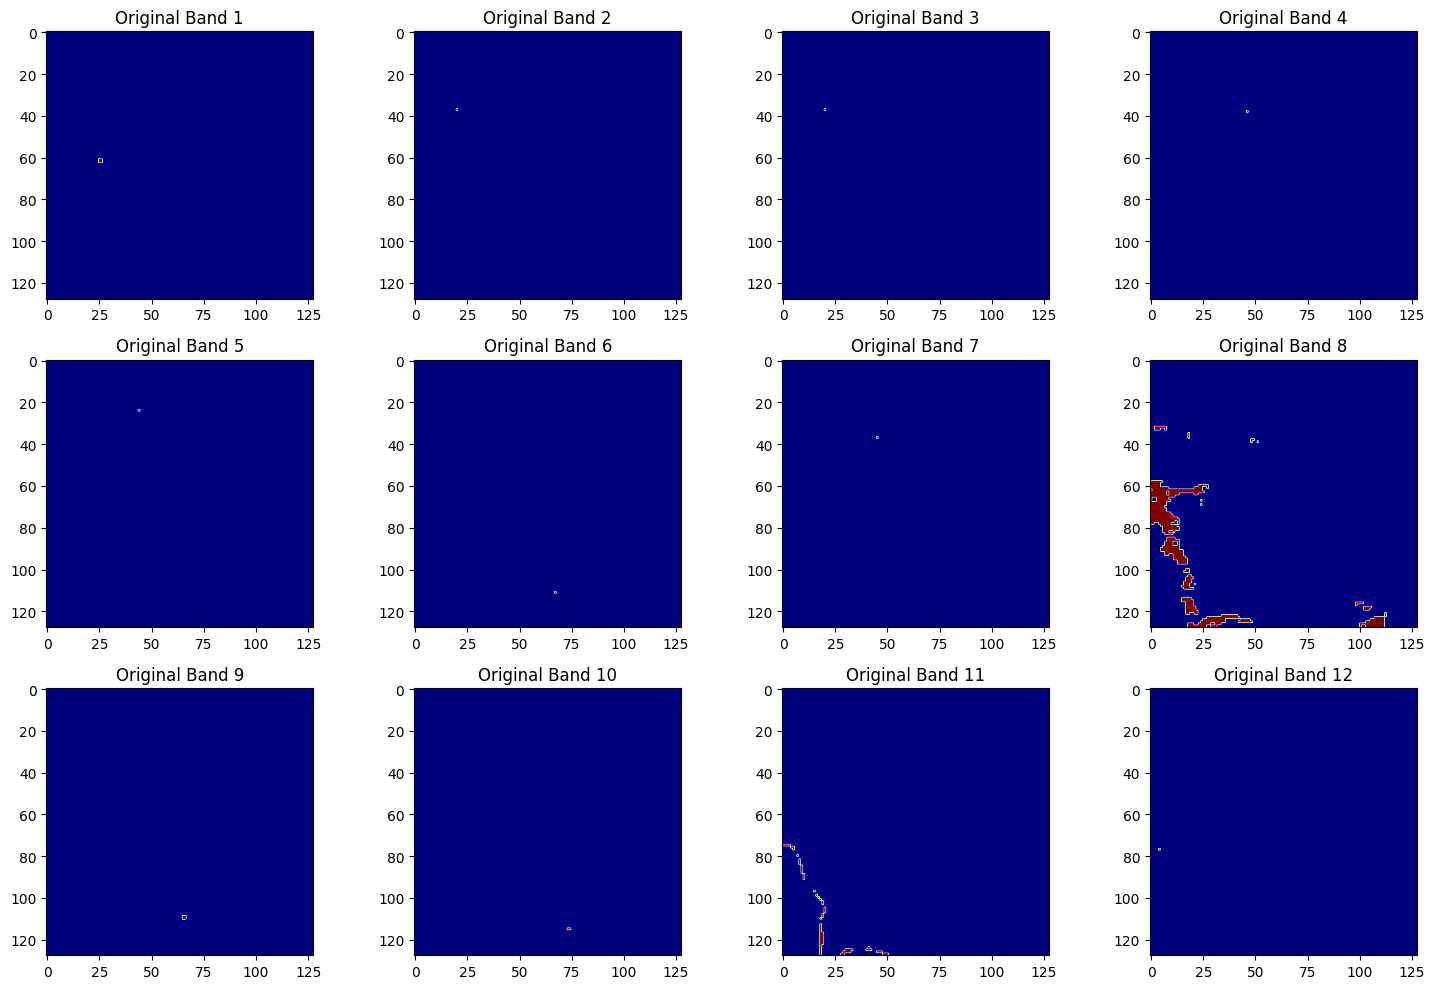

Image 3 shape: (128, 128, 12)


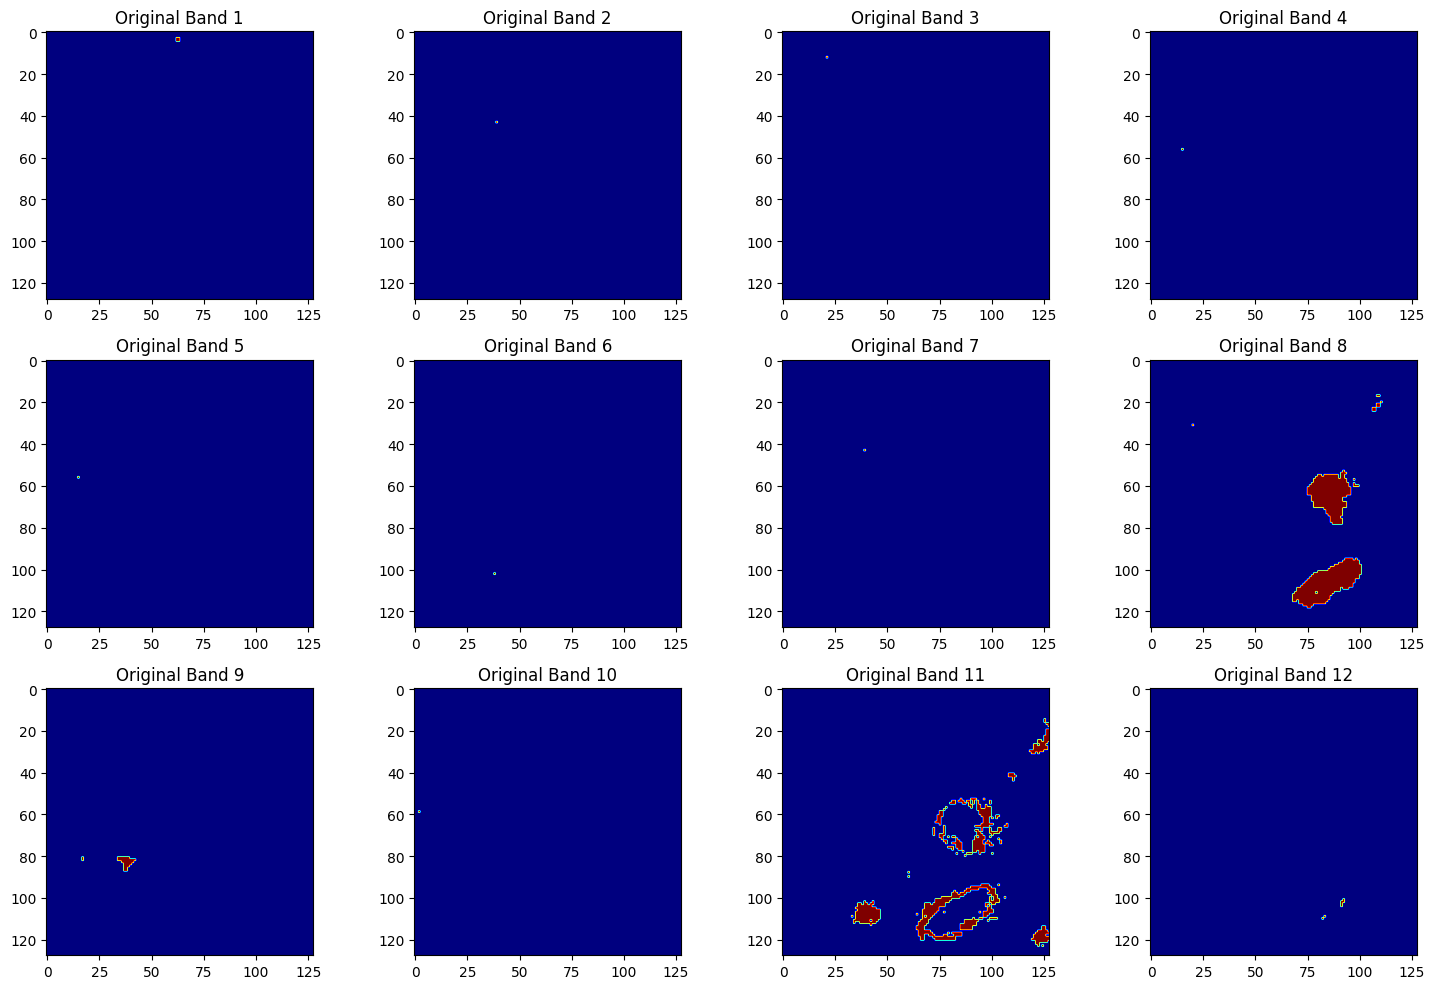

Image 4 shape: (128, 128, 12)


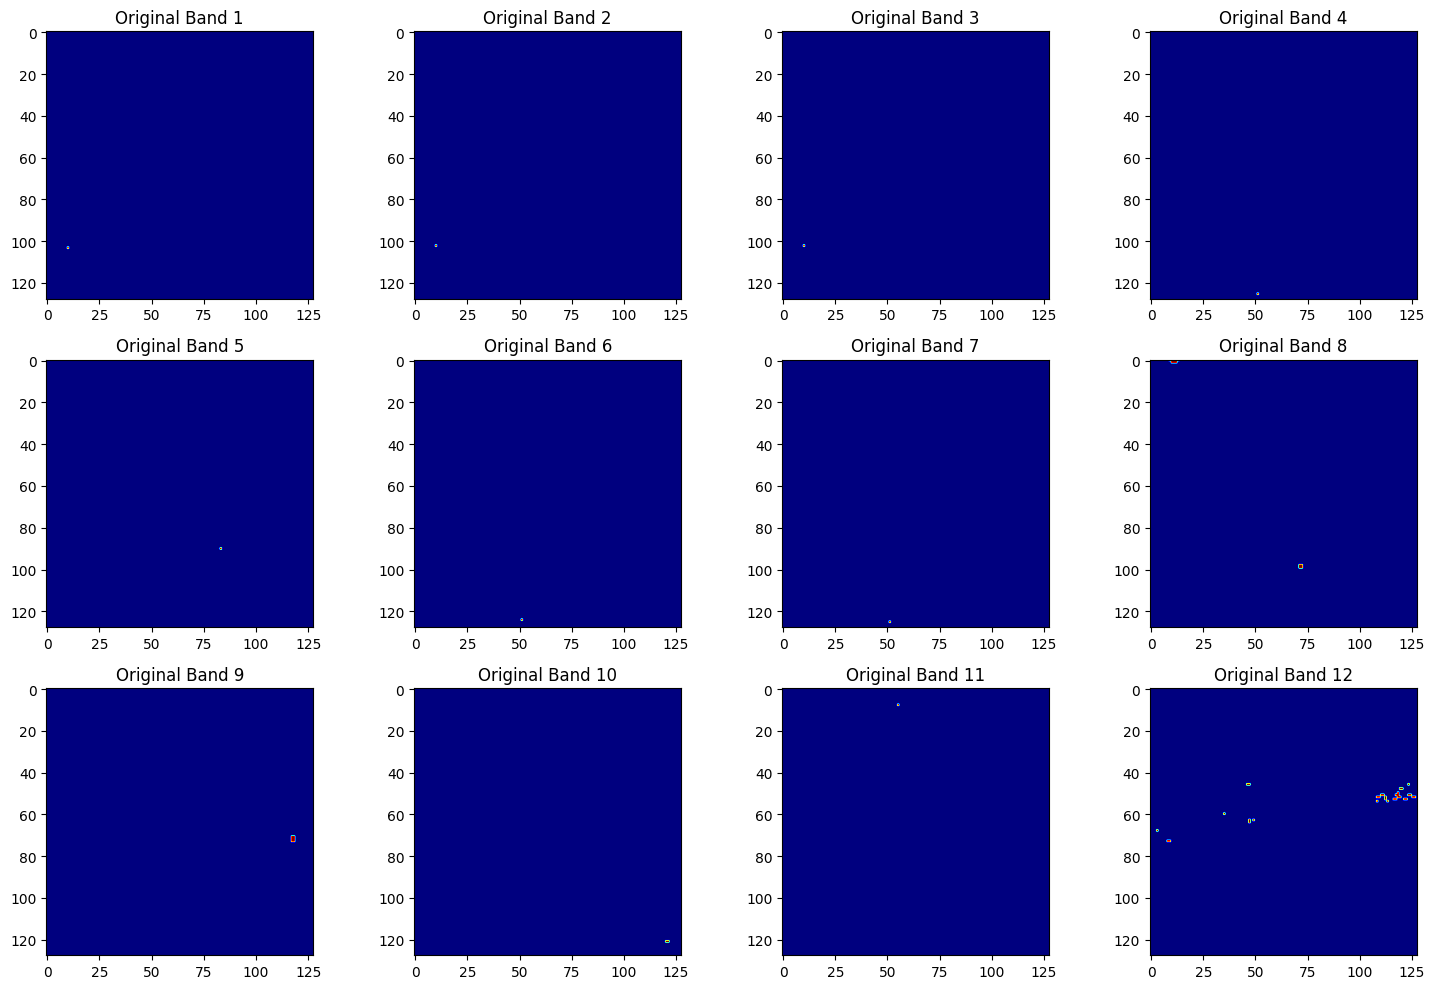

Image 5 shape: (128, 128, 12)


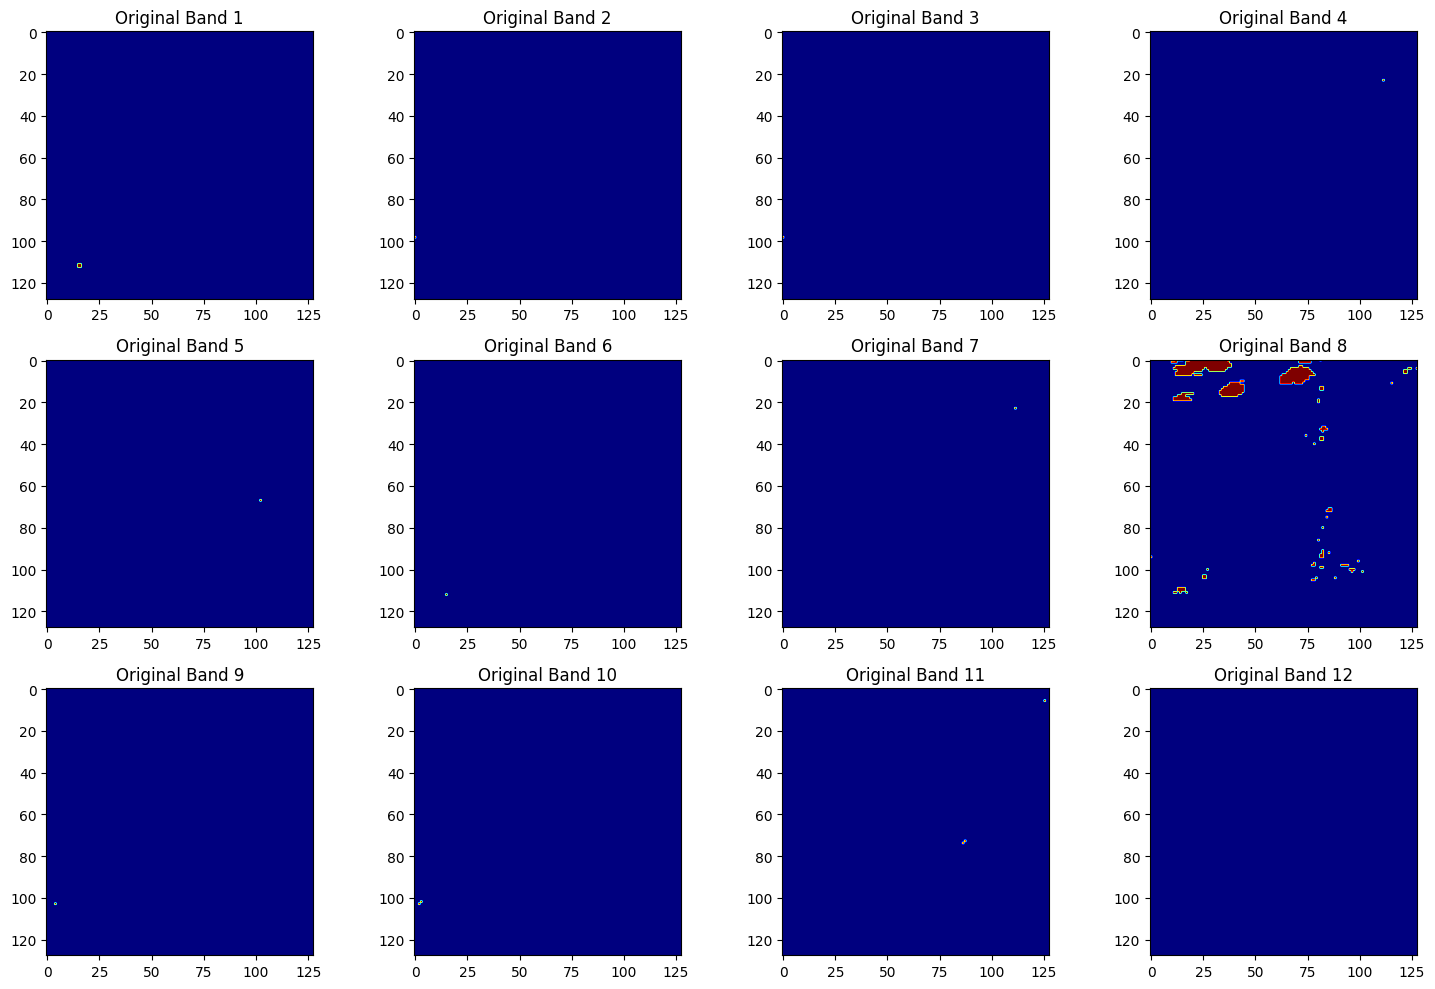

In [8]:
for i in range(5):
    print(f"Image {i+1} shape: {images[i].shape}")

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # Adjust this to ensure 12 bands are displayed in a grid
    for band in range(images[i].shape[-1]):  # Loop over each band (12 bands)
        axes[band // 4, band % 4].imshow(images[i][:, :, band], cmap='jet')
        axes[band // 4, band % 4].set_title(f'Original Band {band + 1}')
    plt.tight_layout()    
    plt.show()

#### RGB composite

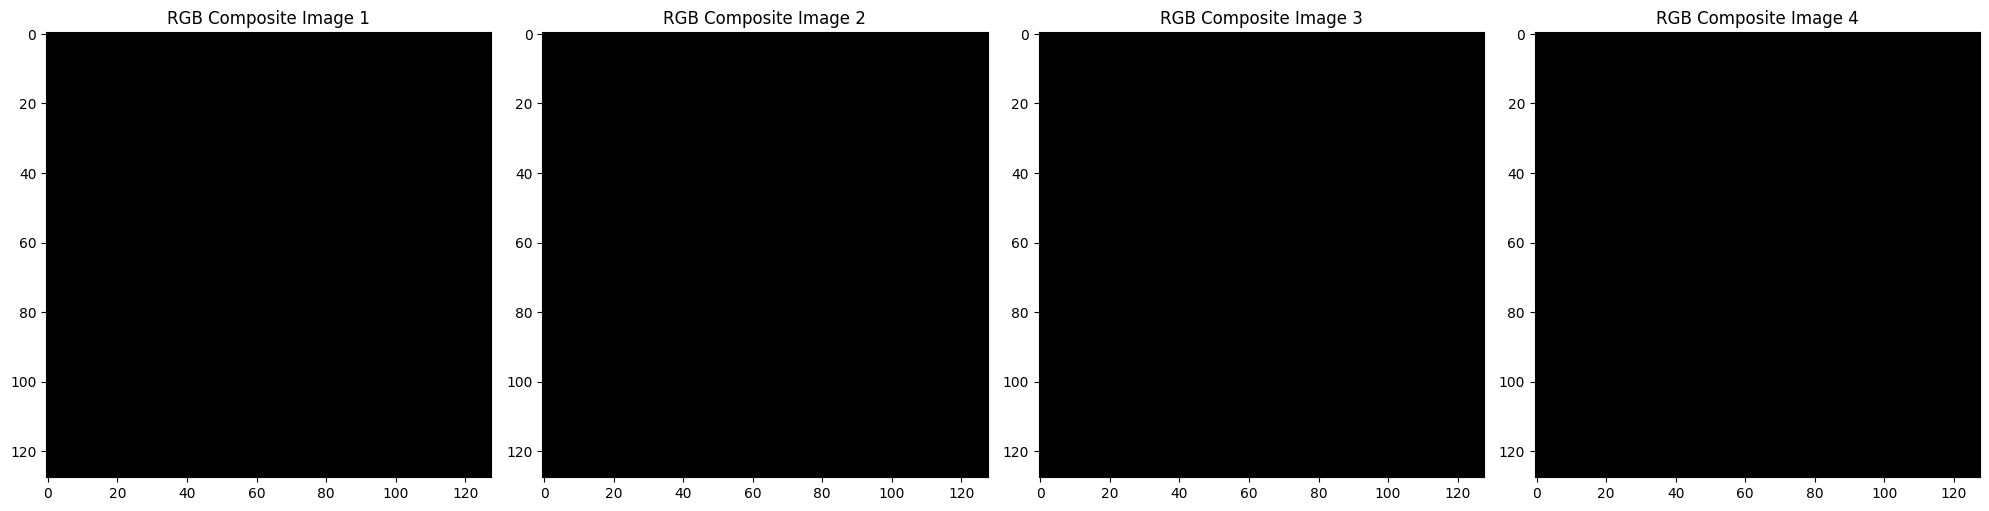

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))  

for i in range(4): 
    rgb_image = images[i][:, :, [3, 2, 1]]  # Assuming Bands 1, 2, and 3 are R, G, B
    axs[i].imshow((rgb_image * 512).astype(np.uint8))
    axs[i].set_title(f'RGB Composite Image {i+1}')
plt.tight_layout()
plt.show()

#### Visualize NDWI

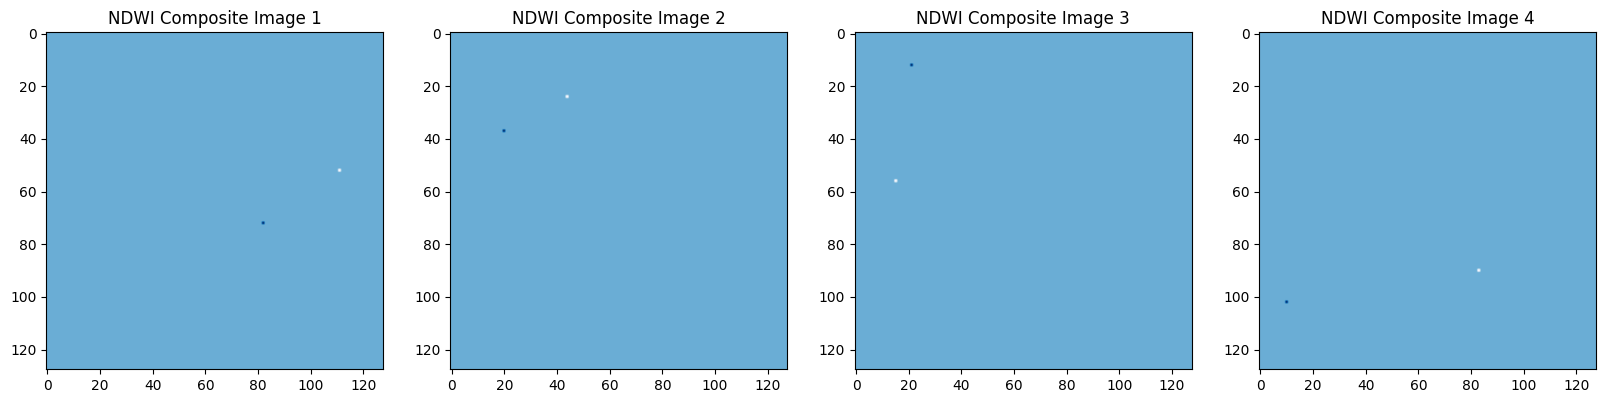

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))  

for i in range(4):  
    ndwi_image = ndwi(images[i])
    plt.figure(figsize=(5, 5))
    axs[i].imshow(ndwi_image, cmap='Blues')
    axs[i].set_title(f'NDWI Composite Image {i+1}')
plt.tight_layout()
plt.show()

#### Visualize Binary Mask for Labels

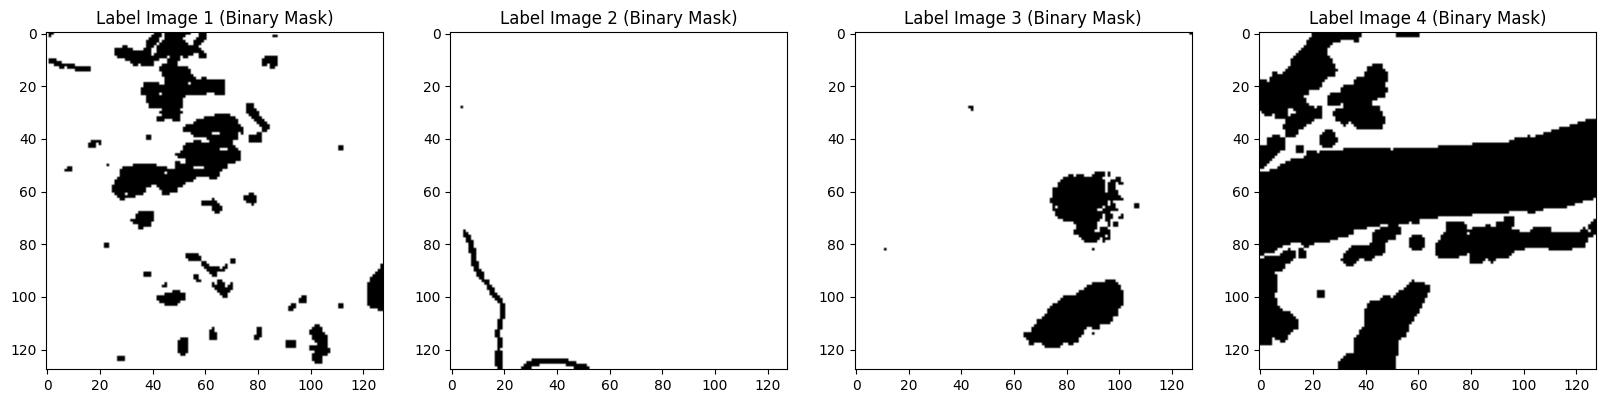

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))  

for i in range(4):  
    plt.figure(figsize=(5, 5))
    axs[i].imshow(labels[i].squeeze(), cmap='binary')
    axs[i].set_title(f'Label Image {i+1} (Binary Mask)')
plt.tight_layout()
plt.show()

### Reshape Labels for Model Training

In [12]:
labels.shape , images.shape

((306, 128, 128), (306, 128, 128, 12))

### Model Training

In [14]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=365)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size=0.5, random_state=42)


### U-Net Model Architecture

##### `Encoder`

##### `Decoder`

##### `U-Net Model`

In [23]:

def resnet_unet(input_shape, num_classes):
    # Input layer with 12 channels (multispectral images)
    inputs = layers.Input(shape=input_shape)

    # Pre-trained ResNet50 as encoder, but modify the first layer to accept 12-channel input
    resnet50 = ResNet50(include_top=False, weights=None, input_tensor=inputs)  # Set weights=None to prevent loading 3-channel weights

    # Rebuild the first layer to accept 12-channel input (replace conv1 layer)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1', use_bias=False)(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Encoder layers (rest of ResNet50, using pre-trained weights if needed)
    enc1 = resnet50.get_layer('conv2_block3_out').output  # 64x64 -> 32x32
    enc2 = resnet50.get_layer('conv3_block4_out').output  # 32x32 -> 16x16
    enc3 = resnet50.get_layer('conv4_block6_out').output  # 16x16 -> 8x8
    enc4 = resnet50.get_layer('conv5_block3_out').output  # 8x8 -> 4x4

    # Decoder with skip connections
    dec4 = layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(enc4)  # 4x4 -> 8x8
    dec4 = layers.concatenate([dec4, enc3])
    dec4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(dec4)
    dec4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(dec4)

    dec3 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(dec4)  # 8x8 -> 16x16
    dec3 = layers.concatenate([dec3, enc2])
    dec3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(dec3)
    dec3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(dec3)

    dec2 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(dec3)  # 16x16 -> 32x32
    dec2 = layers.concatenate([dec2, enc1])
    dec2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(dec2)
    dec2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(dec2)

    dec1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(dec2)  # 32x32 -> 64x64
    dec1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(dec1)
    dec1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(dec1)

    dec0 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(dec1)  # 64x64 -> 128x128
    dec0 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(dec0)
    dec0 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(dec0)

    # Output layer with sigmoid for binary segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(dec0)

    # Define the model
    model = Model(inputs, outputs)
    
    return model

# Define input shape and number of classes (binary segmentation in this case)
input_shape = (128, 128, 12)
num_classes = 1

# Create the model
model = resnet_unet(input_shape, num_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 12  0           ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   37696       ['conv1_pad[0][0]']              
                                                                                            

In [24]:
# Loss Function: Binary Cross-Entropy with Logits Loss
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Optimizer: Adam
optimizer = tf.keras.optimizers.Adam()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50, 200],
    values=[initial_learning_rate, 5e-5, 3e-5]
)

# Adam with dynamic learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile with Adam optimizer and BCEWithLogitsLoss
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])


In [25]:
history = model.fit(
    x_train, y_train,
    epochs=254,
    verbose=1,
    batch_size=16,
    validation_data=(x_val, y_val),
)

Epoch 1/254
16/16 [==============================] - 22s 750ms/step - loss: 0.7474 - accuracy: 0.6825 - val_loss: 0.6976 - val_accuracy: 0.6740
Epoch 2/254
16/16 [==============================] - 7s 408ms/step - loss: 0.6931 - accuracy: 0.6847 - val_loss: 0.6932 - val_accuracy: 0.6740
Epoch 3/254
16/16 [==============================] - 7s 407ms/step - loss: 0.6931 - accuracy: 0.6847 - val_loss: 0.6931 - val_accuracy: 0.6740
Epoch 4/254
16/16 [==============================] - 7s 407ms/step - loss: 0.6931 - accuracy: 0.6847 - val_loss: 0.6931 - val_accuracy: 0.6740
Epoch 5/254
16/16 [==============================] - 7s 408ms/step - loss: 0.6931 - accuracy: 0.6847 - val_loss: 0.6931 - val_accuracy: 0.6740
Epoch 6/254
16/16 [==============================] - 7s 408ms/step - loss: 0.6931 - accuracy: 0.6847 - val_loss: 0.6931 - val_accuracy: 0.6740
Epoch 7/254
16/16 [==============================] - 7s 410ms/step - loss: 0.6931 - accuracy: 0.6847 - val_loss: 0.6931 - val_accuracy: 0.674

KeyboardInterrupt: 

## 